<a href="https://colab.research.google.com/github/FrancisLeung/Stock-Price-Prediction-with-a-hybrid-DL-models-of-stock-price-and-economic-data/blob/main/Multivariate_3_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install tensorflow==2.8.0

In [7]:
import sys
print(sys.version)

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


In [8]:
# Importing dependencies
import numpy as np
np.random.seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow as tf
tf.compat.v1.set_random_seed(2)

import pandas as pd
import matplotlib.pyplot as plt

#Only Tensorflow 2.8.0 can provide keras.models

from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

### Data Preprocessing

In [9]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [10]:
# Loading the dataset
url = '/content/sample_data/CSV.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-15,19.200001,19.639999,19.180000,19.590000,19.590000,146000
2019-02-19,19.500000,19.600000,19.100000,19.549999,19.549999,138100
2019-02-20,19.660000,20.059999,19.520000,19.920000,19.920000,133400
2019-02-21,19.740000,20.790001,19.530001,20.190001,20.190001,167000
2019-02-22,20.389999,21.080000,20.379999,21.000000,21.000000,434100


In [11]:
# Correlation matrix
df.corr()['Close']

Open         0.999440
High         0.999733
Low          0.999712
Close        1.000000
Adj Close    0.999319
Volume       0.237297
Name: Close, dtype: float64

In [12]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    5.672000e+03
mean     6.335628e+04
std      8.749770e+04
min      0.000000e+00
25%      1.850000e+04
50%      3.985000e+04
75%      7.900000e+04
max      2.073400e+06
Name: Volume, dtype: float64


In [13]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    #model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [14]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [15]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [16]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [17]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the features
print(series.shape)
print(series.tail())

(5670, 3)
                Close       High  Volume
Date                                    
2019-02-15  19.590000  19.639999  146000
2019-02-19  19.549999  19.600000  138100
2019-02-20  19.920000  20.059999  133400
2019-02-21  20.190001  20.790001  167000
2019-02-22  21.000000  21.080000  434100


In [18]:
# Train Val Test Split
train_start = dt.date(1997,1,1)
train_end = dt.date(2006,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2007,1,1)
val_end = dt.date(2008,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2009,1,1)
test_end = dt.date(2010,12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(2515, 3) (504, 3) (503, 3)


In [19]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2515, 3) (504, 3) (503, 3)


In [20]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


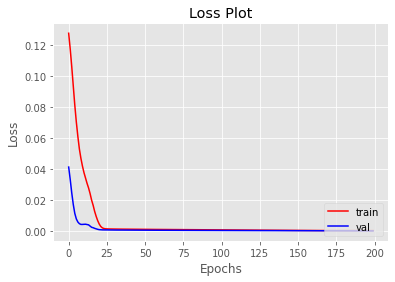

In [21]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 6.249788890931105e-05
RMSE = 0.007905560632194978
R2-Score = 0.9421557414710294


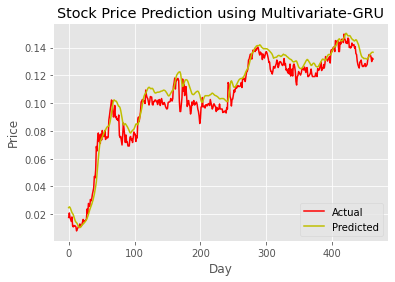

In [22]:
mse,rmse,r2_value,true,predicted = evaluate_model(model,test,40)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [23]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
#del model  #Deletes the model
# Load a model
#model = load_model('MV3-GRU_40_[40,35]_1e-4_64.h5')

## Cross Validation

In [24]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 50

In [25]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(5670, 3)
                Close       High  Volume
Date                                    
2019-02-15  19.590000  19.639999  146000
2019-02-19  19.549999  19.600000  138100
2019-02-20  19.920000  20.059999  133400
2019-02-21  20.190001  20.790001  167000
2019-02-22  21.000000  21.080000  434100


In [26]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.5505618 , 0.55257271, 0.77239184],
       [0.5505618 , 0.55257271, 0.1257898 ],
       [0.54606742, 0.55257271, 0.07847393],
       ...,
       [0.91406745, 0.90693512, 0.02585251],
       [0.93204498, 0.92769575, 0.08074085],
       [0.92737079, 0.92841163, 0.09197897]])

### Split I

In [27]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Split 1
MSE = 0.0002505450136564705
RMSE = 0.015828613762944324
R-Squared Score = 0.6064594321114615


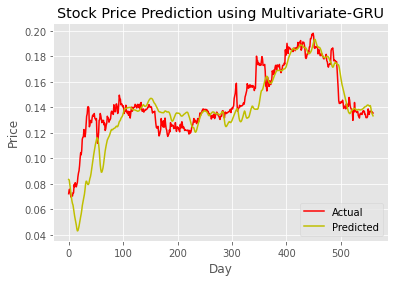

In [29]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-GRU-Split1.h5")

### Split II

Split 2
MSE = 0.0007525025985624481
RMSE = 0.02743178081281724
R-Squared Score = 0.8186418076235891


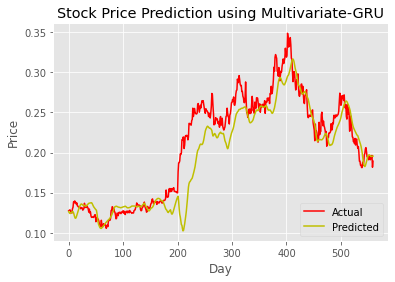

In [30]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split2.h5")

### Split III

Split 3
MSE = 0.00020001104798778475
RMSE = 0.014142526223690898
R-Squared Score = 0.8666755662429414


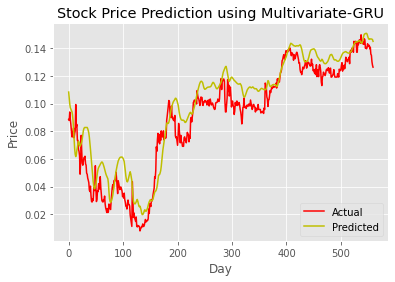

In [31]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split3.h5")

### Split IV

Split 4
MSE = 0.0008155381798787778
RMSE = 0.028557629101148747
R-Squared Score = 0.9592514202530112


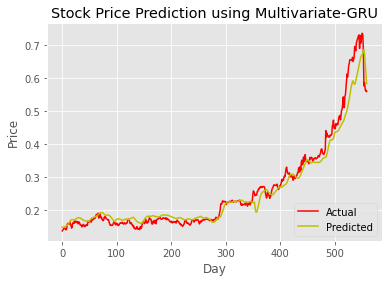

In [32]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
#cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split4.h5")

### Split V

Split 5
MSE = 0.000638235631364727
RMSE = 0.025263325817570556
R-Squared Score = 0.9273586611715875


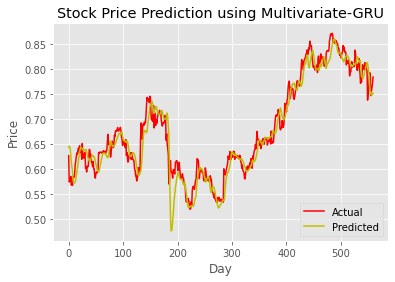

In [33]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split5.h5")

In [34]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.0004603235728928576
Avg. RMSE = 0.020666561654255754
Avg. R2-score = 0.8047838667873949


In [35]:
CV_results.to_csv('MV3-GRU_CrossValidation.csv')
train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')